# Social Media Sanctions and Misinformation Sharing

There has been a lot of discussions on politics and sanctions in social media. Specifically, people with conservative beliefs argue that they are more likely to be sanctioned on social media than those with more liberal beliefs.

If this happens, however, that may not necessarily be the result of different policies on behalf of the social media companies. It may simply be that people with conservative beliefs post online more questionable content, and so they are more likely to be sanctioned even with a completely neutral sanction policy.

In a [recent analysis in Nature](https://www.nature.com/articles/s41586-024-07942-8), Mohshen Moshel et al. investigated whether social media sanctions are politically biased or they are the result of differences in misinformation sharing between people of different political beliefs. The authors argue that that media sanctions are not politically biased. Social media users with conservative political beliefs are more likely to post questionable or misinformation material, and so they are more likely to be sanctioned. In this assignment, you will follow through some of Moshel et al.'s research.

You will use their data, available at [mosleh_et_al_data.csv](mosleh_et_al_data.csv).

In [242]:
import pandas as pd
from scipy.stats import chi2_contingency, zscore

import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

import numpy as np

import statsmodels.api as sm

from sklearn.metrics import roc_auc_score
from sklearn.utils import resample

from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


In [243]:
data = pd.read_csv('mosleh_et_al_data.csv')
data.head()

,politics_sites2,politics_sites1,politics_followed,lowqual_pr2019_crowd,lowqual_pr2019_fc,lowqual_afm,lowqual_mbfc,lowqual_lasser2019,suspended,politics_hashtag,...,valence_neg,valence_neu,valence_pos,politics_sites2_ideo_std,hashtag_ideo_std,barbera_std,politics_sites1_std,repeated_tweet_count,freq_pr_1h,bad_domain_count
0,-0.231902,-1.168745,-0.080295,0.598883,0.279221,0.185315,0.292807,0.350000,0,0,...,0.109935,0.813230,0.076835,0.274317,0.0,0.909460,69,86.0,30,7
1,0.405261,1.060905,2.296375,0.774873,0.848639,0.614156,0.513147,0.975087,0,1,...,0.115985,0.793715,0.090250,0.351800,0.0,0.157056,623,133.0,26,20
2,-0.171067,-0.500076,-2.312730,0.548727,0.242347,0.130950,0.242445,0.300000,0,0,...,0.085765,0.817340,0.096915,0.279591,0.0,0.445349,32,3.0,3,6
3,-0.085814,-0.748035,-1.507481,0.611501,0.360119,0.180055,0.277793,0.316038,0,0,...,0.108680,0.781135,0.110190,0.290277,0.0,0.256665,55,104.0,29,22
4,0.595367,1.347730,2.010573,0.700217,0.698661,0.430655,0.554609,0.763889,0,1,...,0.065145,0.860550,0.074320,0.300823,0.0,0.431149,37,36.0,8,8


## Twitter Suspensions after the 2020 Election

Show, using crosstabulation, that accounts that shared `#Trump2020` during the election were about 4.4 times more likely to be subsequently suspended than the accounts that shared `#VoteBidenHarris2020` (relevant columns: `politics_hashtag` and `suspended`). Then perform a $\chi^2$ test on the contingency table and explain the results.

In [244]:
table = pd.crosstab(
  index=data['politics_hashtag'],
  columns=data['suspended'],
)
table

suspended,0,1
politics_hashtag,,
0,4295,200
1,3623,882


Using the results of the Crosstab Table, we can see that the republicans were about 4.41 times more likely to be subsequently suspended than the accounts of the democrats.

In [245]:
ratio = table.loc[1, 1] / table.loc[0, 1]
ratio

4.41

By performing a $\chi^2$ test we get the following results:
  * $\chi^2$ statistic:
    * **Value:** 485.47
    * A high chi-square value, like 485.47, indicates a substantial deviation from what we would expect if there were no realtionship between account suspendion and political party.
  * p-Value:
    * **Value:** $1.38 \times 10^{-107}$
    * The p-value indicates the probability of observing a chi-square a chi-square value as extreme as 485.47 (or more extreme) under the null hypothesis that account suspension and political party affiliation are independent.
    * A p-value this small (essentially 0) is far below any conventional significance level. This strongly suggests that the null hypothesis of independence can be rejected.
  * Significance:
    * **Result:** True
    * The significance result confirms that the p-value is below the pre-determined significance threshold (**here 5%**).
We can observe from the results that the account suspension is significantly associated with the political party affiliation.

In [246]:
chi2, p, dof, expected = chi2_contingency(table)
significant = p < 0.05 # 5% significance level

chi2, p, significant

(485.46706126582285, 1.3808204811294585e-107, True)

## Distributions of Relative Frequency of Low Quality

Plot the distributions of low-quality sharing as determined by eight professional fact-checkers (column `lowqual_pr2019_fc`), grouped by `politics_hashtag`. The $x$-axis should be standardized using z-scores. The distributions should look like the following figure.

<img src="fig_1.svg"/>

We convert the `lowqual_pr2019_fc` values, to their z-score and save the results in a new column `lowqual_pr2019_fc_zscore`.

In [247]:
data['lowqual_pr2019_fc_zscore'] = zscore(
  a = data['lowqual_pr2019_fc'],
  nan_policy='omit'
)

Text(0, 0.5, 'Frequency')

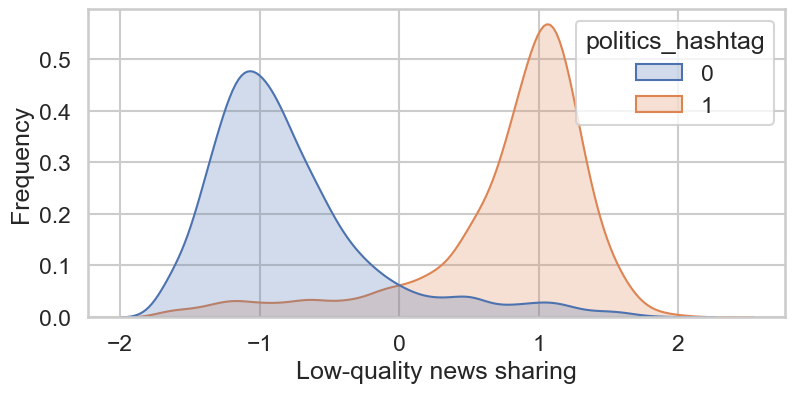

In [248]:
plt.figure(figsize=(9, 4))

sns.kdeplot(
    data = data,
    x = 'lowqual_pr2019_fc_zscore',
    hue = 'politics_hashtag',
    fill= True,
)

plt.xlabel('Low-quality news sharing')
plt.ylabel('Frequency')

In [249]:
## TODO: Add observations here

Having done, that, proceed to do the same with low-quality sharing as determined by crowdsourcing from 971 participants from the USA (column `lowqual_pr2019_crowd`). The distributions should look like the following figure.

<img src="fig_2.svg" />

In [250]:
data['lowqual_pr2019_crowd_zscore'] = zscore(
  a = data['lowqual_pr2019_crowd'],
  nan_policy='omit'
)

Text(0, 0.5, 'Frequency')

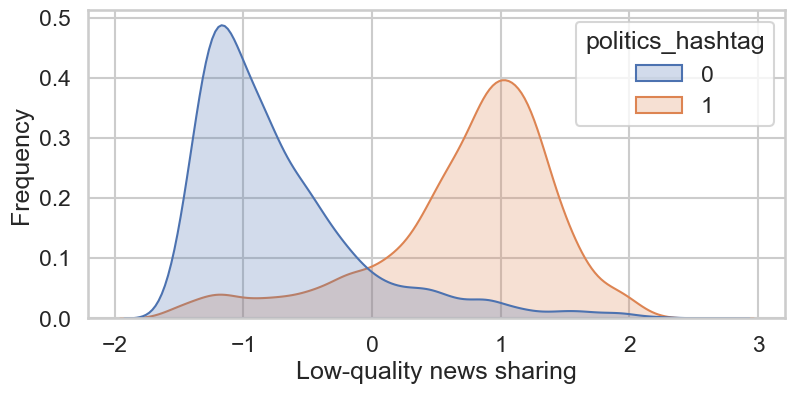

In [251]:
plt.figure(figsize=(9, 4))

sns.kdeplot(
    data = data,
    x = 'lowqual_pr2019_crowd_zscore',
    hue = 'politics_hashtag',
    fill= True,
)

plt.xlabel('Low-quality news sharing')
plt.ylabel('Frequency')

In [ ]:
# TODO: Also add observations here

Show the results of the t-statistic for these two groups as well.

In [252]:
def perform_t_statistic(column):
  groups = data.dropna(subset=[column]).groupby('politics_hashtag')[column].apply(list)

  ttest= stats.ttest_ind(
    groups[0],
    groups[1]
  ) 

  return ttest

In [253]:
ttest = perform_t_statistic('lowqual_pr2019_fc_zscore')

print(ttest)

TtestResult(statistic=-119.22334314832361, pvalue=0.0, df=8943.0)


What we can observe from the results of the **Two Sample T-Test** is:

  * **T-statistic:**
    * A t-statistic of -119.22 is extremely large in absolute value, suggesting a very significant difference between the means of the two groups.
    * The negative sign indicates that the republicans has a lowere mean of low quality news sharing, compared to the democrats.
  * **P-value:**
    * A p-value of 0.0 is essentially zero, meaning the difference between the two groupd is highly statistically significant.
    * This indicates that it is extremely unlikely that the observed difference in means between the two groups is due to random chance. 
    In practical terms, this means the groupd are very different from each other in terms of their low-quality news sharing.
  * **Degrees of freedom:**
    * The degrees of freedom (df = 8943) show that since the sample size is quite large, the statistical power of the test is increased.

In [254]:
ttest = perform_t_statistic('lowqual_pr2019_crowd_zscore')

print(ttest)

TtestResult(statistic=-102.46401373884626, pvalue=0.0, df=8943.0)


When using low-quality sharing data determined through crowdsourcing from 971 participants in the USA, we obtain similar results. This further strengthens the reliability of our findings.

## Low-quality News Sharing on Twitter

We will proceed to examine low-quality news sharing on Twitter on a more quantitave manner, using the t-test. In particular, we will use the t-test based on groups of users depending on their `politics_hashtag` and various assessments of low-quality news sharing. We will quantify the effect size of the t-test using Cohen's $d$ and Hedges' $g$.

Cohen's $d$ is defined as the difference between two means divided by a standard deviation for the data, i.e.:

$$ d = \frac{\bar{x}_{1} - \bar{x}_{2}}{s} $$

$s$, the pooled standard deviation for two independent samples is defined as:

$$ s=\sqrt{\frac{(n_{1}-1)s_{1}^{2}+(n_{2}-1)s_{2}^{2}}{n_{1}+n_{2}-2}} $$

where $n_1$, $n_2$ is the size of each sample and the variance of $s_1$ is defined as:

$$ s_{1}^{2}=\frac{1}{n_{1}-1} \sum _{i=1}^{n_{1}}(x_{1,i}-{\bar {x}}_{1})^{2} $$

with the variance of $s_2$ defined similarly. The values of Cohen's $d$ can be interpreted as follows:

| Effect Size | $d$  |
|-------------|------|
| Very small  | 0.01 |
| Small	      | 0.20 |
| Medium	  | 0.50 |
| Large	      | 0.80 |
| Very large  | 1.20 |
| Huge        | 2.00 |

Hedges' $g$ corrects Cohen's $d$ for bias in small sample sizes and is defined as:

$$ 1 - \bigg(\frac{3}{4  (n_1 + n_2) - 9)}\bigg)d $$

You will perform a t-test statistic and report Cohen's $d$ and Hedges' $g$ for the following, grouped by `politics_hashtag`.

* `lowqual_pr2019_fc` (sites rated by fact-checkers)
* `lowqual_afm` (sites rated by Ad Fontes media, <https://adfontesmedia.com/>)
* `lowqual_mbfc` (sites rated by Media Bias/Fact Check, <https://mediabiasfactcheck.com/>)
* `lowqual_lasser2019` (sites rated by Laser et al., https://doi.org/10.1093/pnasnexus/pgac186)
* `lowqual_pr2019_crowd` (sites rated by crowdsourcing 971 participants from the USA)
* `lowqual_pr2019_crowdrep` (sites rated by the republicans among the 971 participants of above)

In [255]:
# Function to calculate pooled standard deviation
def pooled_std(group1, group2):
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    return np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))

# Function to calculate Cohen's d
def cohens_d(group1, group2):
    s_pooled = pooled_std(group1, group2)
    return (np.mean(group1) - np.mean(group2)) / s_pooled

# Function to calculate Hedges' g
def hedges_g(cohens_d, n1, n2):
    correction = 1 - (3 / (4 * (n1 + n2) - 9))
    return cohens_d * correction

def calculate_d_and_g(column):
    groups = data.dropna(subset=[column]).groupby('politics_hashtag')[column].apply(list)

    d = cohens_d(groups[0], groups[1])
    g = hedges_g(d, len(groups[0]), len(groups[1]))

    return d, g

In [256]:
columns = [
    'lowqual_pr2019_fc',
    'lowqual_afm',
    'lowqual_mbfc',
    'lowqual_lasser2019',
    'lowqual_pr2019_crowd',
    'lowqual_pr2019_crowdrep'
]

In [257]:
results = []

# Perform the test and calculations for each column
for column in columns:
    t_stat, p_val = perform_t_statistic(column)
    
    d, g = calculate_d_and_g(column)
    
    results.append({
        'Column': column,
        'T-statistic': t_stat,
        'P-value': p_val,
        'Cohen\'s d': d,
        'Hedges\' g': g
    })

results_df = pd.DataFrame(results)
results_df

,Column,T-statistic,P-value,Cohen's d,Hedges' g
0,lowqual_pr2019_fc,-119.223343,0.0,-2.521188,-2.520977
1,lowqual_afm,-102.677719,0.0,-2.164878,-2.164698
2,lowqual_mbfc,-97.592231,0.0,-2.057540,-2.057369
3,lowqual_lasser2019,-102.633746,0.0,-2.163831,-2.163650
4,lowqual_pr2019_crowd,-102.464014,0.0,-2.166782,-2.166601
5,lowqual_pr2019_crowdrep,-61.071485,0.0,-1.291464,-1.291356


1. **T-statistics**:  
   - The negative t-statistics indicate that the mean low-quality news sharing is higher for democrats than for republicans in all categories.  
   - The magnitude of the t-statistics reflects the strength of this difference, with larger absolute values indicating greater differences between the groups.  

2. **P-values**:  
   - All p-values are 0.0, indicating that the differences between the two groups are statistically significant.  
   - This means the observed differences in low-quality news sharing are highly unlikely to have occurred by chance.  

3. **Effect Sizes**:  
   - **Cohen’s d** and **Hedges’ g** quantify the magnitude of the differences:  
     - For most categories, the effect sizes are large (`|d| > 0.8`), suggesting substantial differences between the groups.  
     - The smallest effect size is for `lowqual_pr2019_crowdrep` (`Cohen's d = -1.291356`), indicating a relatively smaller, though still large, difference for the ratings provided by Republicans in the crowdsourcing dataset.  

4. **Consistency Across Columns**:  
   - The results are consistent across all measures of low-quality news sharing.  
   - This supports the conclusion that Democrats are more likely to share low-quality news, regardless of how it is assessed (e.g., by fact-checkers, Ad Fontes Media, or crowdsourcing).  

### Sharing Lower-quality News Sources and Conservative Ideology

To see if there is a correlation between lower-quality news sources and conservative ideology, you will perform pairwise correlations between, on the one hand:

 * `lowqual_pr2019_fc`
 * `lowqual_lasser2019`
 * `lowqual_mbfc`
 * `lowqual_afm`
 * `lowqual_pr2019_crowd`
 * `lowqual_pr2019_crowdrep`

and on the other hand:

 * `politics_followed` (political ideology estimated on the basis of Twitter accounts user followed)
 * `politics_hashtag`
 * `politics_sites1` (political ideology estimated on the basis of the news sites the users share, <https://doi.org/10.1126/science.aau2706>)
 * `politics_sites2` (political ideology estimated on the basis of the news sites ther users share, <https://doi.org/10.31219/osf.io/ch8gj>)

You should display the results in a heatmap like the following:

<img src="fig_3.svg"/>

In [258]:
low_quality_columns = [
    'lowqual_pr2019_fc', 'lowqual_lasser2019', 'lowqual_mbfc', 
    'lowqual_afm', 'lowqual_pr2019_crowd', 'lowqual_pr2019_crowdrep'
]
political_ideology_columns = [
    'politics_followed', 'politics_hashtag', 'politics_sites1', 'politics_sites2'
]

# Compute and display correlations
correlation_results = data[low_quality_columns + political_ideology_columns].corr().loc[low_quality_columns, political_ideology_columns]
correlation_results

,politics_followed,politics_hashtag,politics_sites1,politics_sites2
lowqual_pr2019_fc,0.809501,0.783463,0.876237,0.854197
lowqual_lasser2019,0.777250,0.734398,0.835576,0.851794
lowqual_mbfc,0.748146,0.717101,0.774779,0.774266
lowqual_afm,0.768887,0.734562,0.845285,0.833632
lowqual_pr2019_crowd,0.754001,0.734856,0.811904,0.784861
lowqual_pr2019_crowdrep,0.540993,0.542505,0.576336,0.552613


(array([0.5, 1.5, 2.5, 3.5]),
 [Text(0.5, 0, 'politics_followed'),
  Text(1.5, 0, 'politics_hashtag'),
  Text(2.5, 0, 'politics_sites1'),
  Text(3.5, 0, 'politics_sites2')])

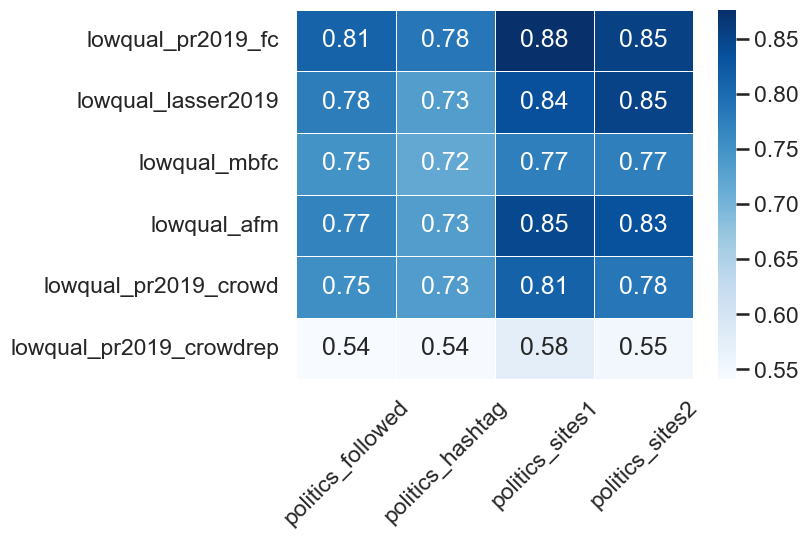

In [259]:
sns.heatmap(
    correlation_results,
    annot=True,
    linewidth=0.5,
    cmap='Blues',
)

plt.xticks(rotation=45)

## News Sharing Can Help Explain Suspension, Using Single Predictors

You will use the following predictors to predict whether a user was suspended or not:

  * `politics_hashtag`
  * `politics_sites1`
  * `politics_sites2`
  * `politics_followed`
  * `lowqual_afm`
  * `lowqual_mbfc`
  * `lowqual_lasser2019`
  * `lowqual_pr2019_fc`
  * `lowqual_pr2019_crowd`

The predictions will be with a probit model. The probit model is an alternative to logit, but while the latter uses the logit as the *link function*, the probit model uses the inverse of the cumulative distribution function (CDF) of the standard normal distribution (denoted as $\Phi^{-1}$) as the link function. Mathematically:

$$ \Phi^{-1}(P(Y = 1 | X)) = X\beta $$

where $P(Y = 1  | X)$ is the probability of the event occurring, $X$ represents the independent variables, and $\beta$ is the vector of coefficients.

The predictions will be evaluated with the AUC of the ROC curve. To get confidence intervals, repeat each prediction 100 times by using the boostrap method. 

Print the AUC and the confidence intervals in a table. Then use them to plot all your evaluations and the confidence intervals in a barchart like the following:

<img src="fig_4.svg" />

In [260]:
# The following method implements the bootstrapping using Probit model prediction
def model_prediction_and_evaluation(X, y, n, alpha):
  aucs = []
  auc_scores = []

  for _ in range(n):

    X_resampled, y_resampled = resample(X, y)
    
    # Add intercept column to X
    X_resampled = sm.add_constant(X_resampled)
    
    model = sm.Probit(y_resampled, X_resampled).fit(disp=False)

    y_pred = model.predict(X_resampled)

    auc = roc_auc_score(y_resampled, y_pred)

    aucs.append(auc)

  auc_scores = np.mean(aucs)
  ci_lower, ci_upper = np.percentile(aucs, [100 * alpha / 2, 100 * (1 - alpha / 2)])

  return auc_scores, ci_lower, ci_upper


In [261]:
po_predictors = [
    'politics_hashtag', 'politics_sites1', 'politics_sites2', 'politics_followed'
]

lq_predictors = [
    'lowqual_afm', 'lowqual_mbfc', 'lowqual_lasser2019', 'lowqual_pr2019_fc', 'lowqual_pr2019_crowd'
]

po_predictors_label = [
    'Hashtag shared', 'News sites shared 1', 'News sites shared 2', 'Accounts followed'
]

lq_predictors_label = [
    'AFM ratings', 'MFBC ratings', 'Lasser ratings', 'Fact-checker ratings', 'Layperson ratings'
]

target = 'suspended'

In [262]:
# The following method executes the boostrap for each predictor column and then saves results in a dataframe, which it returns.
def evaluate_predictors(predictors, labels, data, target, fill_strategy='mean', n_iter=100, alpha=0.05):
    results = []
    
    # Fill missing values for the target variable
    y = data[target].copy()
    y.fillna(y.mean() if fill_strategy == 'mean' else 0, inplace=True)

    for predictor, label in zip(predictors, labels):
        # Fill missing values for predictor variables
        X = data[predictor].copy()
        X.fillna(X.mean() if fill_strategy == 'mean' else 0, inplace=True)

        # Get AUC and confidence intervals
        auc_scores, ci_lower, ci_upper = model_prediction_and_evaluation(X, y, n_iter, alpha)

        results.append({
            "Predictor": predictor,
            "Predictor label": label,
            "Mean AUC": auc_scores,
            "CI Lower": ci_lower,
            "CI Upper": ci_upper,
            "Confidence Interval": ci_upper - ci_lower
        })

    return pd.DataFrame(results)


In [263]:
# Calculate the evaluation project for each type of predictors, and save the results in a corresponding dataframe.
po_predictors_results_df = evaluate_predictors(po_predictors, po_predictors_label, data, target, fill_strategy='0')
lq_predictors_results_df = evaluate_predictors(lq_predictors, lq_predictors_label, data, target, fill_strategy='0')

In [264]:
po_predictors_results_df

,Predictor,Predictor label,Mean AUC,CI Lower,CI Upper,Confidence Interval
0,politics_hashtag,Hashtag shared,0.678755,0.666374,0.690621,0.024248
1,politics_sites1,News sites shared 1,0.700630,0.684739,0.714039,0.029300
2,politics_sites2,News sites shared 2,0.705447,0.689681,0.716885,0.027203
3,politics_followed,Accounts followed,0.682319,0.665925,0.696581,0.030657


In [265]:
lq_predictors_results_df

,Predictor,Predictor label,Mean AUC,CI Lower,CI Upper,Confidence Interval
0,lowqual_afm,AFM ratings,0.715482,0.701693,0.728184,0.026490
1,lowqual_mbfc,MFBC ratings,0.705530,0.690632,0.718095,0.027463
2,lowqual_lasser2019,Lasser ratings,0.707318,0.691560,0.722773,0.031213
3,lowqual_pr2019_fc,Fact-checker ratings,0.699572,0.682720,0.713702,0.030982
4,lowqual_pr2019_crowd,Layperson ratings,0.686902,0.673248,0.700237,0.026989


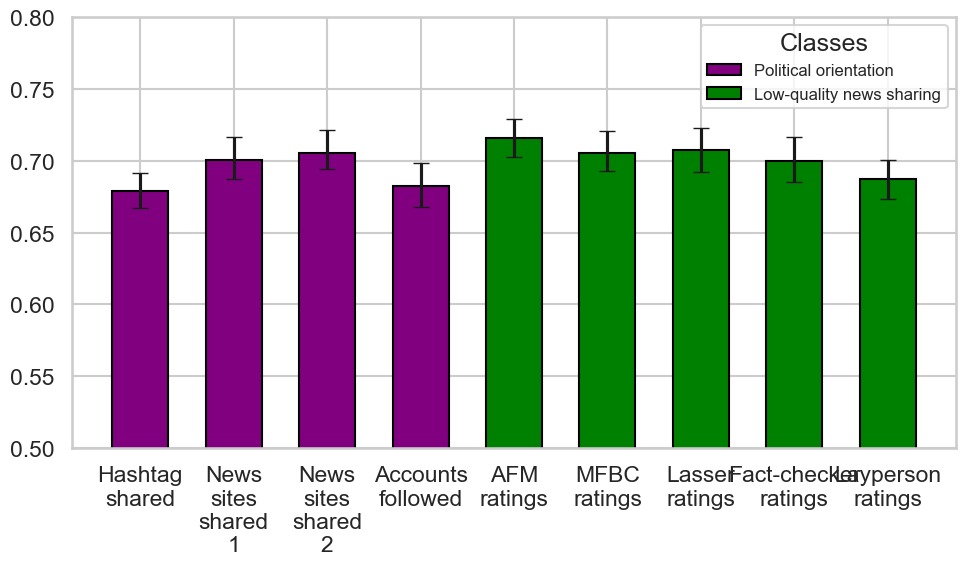

In [266]:
# Data preparation
bar_data = [
    (po_predictors_results_df, 'Political orientation', 'purple'),
    (lq_predictors_results_df, 'Low-quality news sharing', 'green')
]

plt.figure(figsize=(10, 6))
bar_width = 0.6

for df, label, color in bar_data:

    wrapped_labels = ['\n'.join(label.split()) for label in df['Predictor label']] # Make the labels on the x axis not intersect with each other
    yerr = [df['CI Upper'] - df['Mean AUC'], df['Mean AUC'] - df['CI Lower']]  # Compute the Condifence interval line
    
    plt.bar(
        wrapped_labels,
        df['Mean AUC'],
        width=bar_width,
        label=label,
        color=color,
        yerr=yerr,
        capsize=6,
        edgecolor='black'
    )

# Create the ticks from 0 to 0.8 with step 0.05
plt.ylim(0.5, 0.8)
plt.yticks(np.arange(0.5, 0.80, 0.05))

plt.legend(fontsize=12, title='Classes')
plt.tight_layout()


* **Political Orientation Predictors**: The predictors related to political orientation show a moderate range of AUC values. They provide a decent level of classification accuracy, with the highest predictor being related to news sites shared. This implies that political orientation based on social media behavior can be moderately identified using these predictors.

* **Low-Quality News Sharing Predictors**: The AUC values for low-quality news sharing predictors are higher than those for political orientation predictors. This suggests that predicting whether an account shares low-quality news might be more reliable than predicting political orientation. The highest predictor in this group relates to AFM ratings.

* **Predictor Performance Comparison**: The AUC values for both groups indicate that low-quality news sharing predictors generally provide better classification performance than political orientation predictors. This could be due to the more straightforward nature of identifying low-quality news based on user behavior.

* **Confidence Intervals**: The confidence intervals for the predictors are relatively narrow, indicating a stable estimate of the AUC values, although political orientation predictors generally show slightly wider confidence intervals.

* **General Insights**: The results suggest that social media activity, such as sharing news or following accounts, can provide useful signals for determining both political orientation and the likelihood of sharing low-quality news. However, the latter may offer more reliable and stable predictions.

## News Sharing Can Help Explain Suspension, Using Multiple Predictors

You will also use multiple regression models to predict and explain suspension. 

Start by filing in missing values in your data by using the column mean. Then log transform, base 10, the variables that are related to Tweeter metrics, i.e.:

* `repeated_tweet_count` to `log_repeated_tweet_count`
* `freq_pr_1h` (maximum frequency of primary tweets in an hour) to `log_freq_pr_1h`
* `num_followers` to `log_num_followers`
* `num_friends` to `log_num_friends`

Introduce an additional variable, `log_fol`, which should the be base 10 logarithm of `num_friends` over `num_followers` ratio. To prevent out of domain errors, add 1 to each variable when using it in the transforms.

In [267]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 44 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   politics_sites2              9000 non-null   float64
 1   politics_sites1              9000 non-null   float64
 2   politics_followed            7965 non-null   float64
 3   lowqual_pr2019_crowd         8945 non-null   float64
 4   lowqual_pr2019_fc            8945 non-null   float64
 5   lowqual_afm                  8998 non-null   float64
 6   lowqual_mbfc                 8999 non-null   float64
 7   lowqual_lasser2019           8999 non-null   float64
 8   suspended                    9000 non-null   int64  
 9   politics_hashtag             9000 non-null   int64  
 10  lowqual_pr2019_crowdrep      8945 non-null   float64
 11  num_followers                9000 non-null   int64  
 12  num_friends                  9000 non-null   int64  
 13  tweets_in_2wk     

We can see that multiple columns have nan values in the dataframe. We will replace all nan values using the **mean replacement method**.


In [268]:
data = data.apply(
    lambda column: column.fillna(column.mean()) if column.isnull().any() else column
    )

In [269]:
log_columns = [
    ('repeated_tweet_count', 'log_repeated_tweet_count'),
    ('freq_pr_1h', 'log_freq_pr_1h'),
    ('num_followers', 'log_num_followers'),
    ('num_friends', 'log_num_friends'),
]

# Create new columns containing the log10 column of the old ones
for column, log_column in log_columns:
    data[log_column] = np.log10(data[column] + 1)

data['log_num_fol'] = np.log10((data['num_friends'] + 1) / (data['num_followers'] + 1))

To reduce the effect of outliers, you will [winsorize](https://en.wikipedia.org/wiki/Winsorizing) the data. Winzorize from both sides at the top 1% the following variables:

* `valence_neg`
* `valence_neu`
* `valence_pos`
* `barbera_std`
* `politics_sites1_std`
* `politics_sites2_ideo_std`

The `valence_*`, variables were calculated using VADER (<https://doi.org/10.1609/icwsm.v8i1.14550>). The `barbera_std` variable was calculated based on the work of Barbera et al. (<https://doi.org/10.1177/0956797615594620>).

In [270]:
columns = [
    'valence_neg', 'valence_neu', 'valence_pos', 'barbera_std', 'politics_sites1_std', 'politics_sites2_ideo_std'
]

for column in columns:
    data[column] = winsorize(data[column], (0.01, 0.01))

Winsorize the upper side of the following  variables at the top 1%:

* `moral_outrage`
* `rewire_abuse`
* `rewire_hate`
* `rewire_profanity`
* `rewire_violent`
* `rewire_sexually_explicit`
* `jigsaw_toxicity`
* `jigsaw_severe_toxicity`
* `jigsaw_idenity_attack`
* `jigsaw_insult`
* `jigsaw_profanity`
* `jigsaw_threat`

The `moral_outrage` variable was calculated based on the work of Brady et al. (<https://doi.org/doi:10.1126/sciadv.abe5641>). The `rewire_*` variables were calculated using the Rewire Online API (acquired by ActiveFence in 2023)., The `jigsaw_*` variables were calculated using the Google Jigsaw Perspective API (<https://jigsaw.google.com/>, <https://perspectiveapi.com/>).

In [271]:
columns = [
    'moral_outrage', 'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent', 'rewire_sexually_explicit',
    'jigsaw_toxicity', 'jigsaw_severe_toxicity', 'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]

for column in columns:
    data[column] = winsorize(data[column], (0, 0.01))

You will derive and use a single PCA component, `pc1_misinfo`, for low quality news sharing, that is, the variables:

* `lowqual_pr2019_fc`
* `lowqual_afm`
* `lowqual_lasser2019`
* `lowqual_mbfc`

Show the explained variance ratio. Then project the low quality news sharing dimensions to this new dimension.

In [272]:
# This method computes pc1 and returns the values and the explained variance ration.
def compute_first_pca(data, columns):
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data[columns])
    
    # Apply PCA
    pca = PCA(n_components=1)
    pc1 = pca.fit_transform(standardized_data).flatten()
    
    # Get the explained variance ratio of the first component
    explained_variance_ratio = pca.explained_variance_ratio_[0]
    
    return pc1, explained_variance_ratio

In [273]:
columns = [
    'lowqual_pr2019_fc', 'lowqual_afm', 'lowqual_lasser2019', 'lowqual_mbfc'
    ]

pc1, explained_variance_ratio = compute_first_pca(data, columns)

data['pc1_misinfo'] = pc1
print(f"Explained Variance Ratio: {explained_variance_ratio}")

Explained Variance Ratio: 0.8725595303656107


We can observe that the first principas component accounts for approximately **87.25%** of the total variance in the political orientation variables. This is acceptable, since by losing very little information (only about 12%), we reduce the complexity of our model.

We will work in the same way for the political orientation, getting a single PCA component, `pc1_politics`, for the variables:

* `politics_hashtag`
* `politics_followed`
* `politics_sites1`
* `politics_sites2`

Show the explained variance ratio and project the political orientation dimensions to this new dimension.

Introduce a new variable, `extremity`, which is the absolute value of the PCA component you got.

In [274]:
columns = [
    'politics_hashtag', 'politics_followed', 'politics_sites1', 'politics_sites2'
    ]

pc1, explained_variance_ratio = compute_first_pca(data, columns)

data['pc1_politics'] = pc1
data['extremity'] = np.abs(data['pc1_politics'])
print(f"Explained Variance Ratio: {explained_variance_ratio}")

Explained Variance Ratio: 0.8795293696695505


We can observe that the first principas component accounts for approximately **87.95%** of the total variance in the political orientation variables. This is acceptable, since by losing very little information (only about 12%), we reduce the complexity of our model.

Also do the same for `log_num_followers`, `log_num_friends`, `log_num_fol`, producing `pc1_fol`.

In [275]:
columns = [
    'log_num_followers', 'log_num_friends', 'log_num_fol'
]

pc1, explained_variance_ratio = compute_first_pca(data, columns)

data['pc1_fol'] = pc1
print(f"Explained Variance Ratio: {explained_variance_ratio}")

Explained Variance Ratio: 0.7046296894709709


We can observe that the first principas component accounts for approximately **70.46%** of the total variance in the political orientation variables. This is acceptable, since by losing very little information (only about 30%), we reduce the complexity of our model.

Regarding the harmful language variables, perform PCA for *three* components, `pc1_harmful_language`, `pc2_harmful_language`, `pc3_harmful_language`, on the winsorized data of:

* `rewire_abuse`
* `rewire_hate`
* `rewire_profanity`
* `rewire_violent`
* `rewire_sexually_explicit`
* `jigsaw_toxicity`
* `jigsaw_severe_toxicity`
* `jigsaw_idenity_attack`
* `jigsaw_insult`
* `jigsaw_profanity`
* `jigsaw_threat`

Why use three components instead of one in this case? Try to interpret each of the principal components.

In [ ]:
def compute_pca_three_components(data, columns, winsorize_limits=(0.05, 0.05)):
    # Standardize the data
    scaler = StandardScaler()
    standardized_data = scaler.fit_transform(data[columns])
    
    # Apply PCA for three components
    pca = PCA(n_components=3)
    principal_components = pca.fit_transform(standardized_data)
    
    # Create a DataFrame containing the results of each component
    pca_df = pd.DataFrame(
        principal_components, 
        columns=['pc1_harmful_language', 'pc2_harmful_language', 'pc3_harmful_language']
        )
    
    return pca_df, pca.explained_variance_ratio_

In [277]:
columns = [
    'rewire_abuse', 'rewire_hate', 'rewire_profanity', 'rewire_violent', 
    'rewire_sexually_explicit', 'jigsaw_toxicity', 'jigsaw_severe_toxicity', 
    'jigsaw_idenity_attack', 'jigsaw_insult', 'jigsaw_profanity', 'jigsaw_threat'
]

In [278]:
# Compute PCA for harmful language variables
pca_results, explained_variance_ratio = compute_pca_three_components(data, columns)

# Add the PCA components to the original dataset
data = pd.concat([data, pca_results], axis=1)

print(f"Explained Variance Ratio: {explained_variance_ratio}")

Explained Variance Ratio: [0.5616608  0.11871792 0.10703707]


We can think of each of the Principal components as follows:
  * **PC1 (Overall Harmfulness)**
    * Likely dominated by variables like `jigsaw_tocixity`, `rewire_abuse`, and `rewire_hate`, representing the overall level of harmfulness in the text.
  * **PC2 (Type of Harmfulness)**
    * May distinquish between different types of harmful language. `rewire_sexually_explicit` and `jigsaw_idenity_attack` might load heavily on this component, differentiating explicit content from identity-related attacks.
  * **PC3 (Intensity vs Threat)**
    * Could capture subtler aspects, such as distinquish between profance language `rewire_profanity` and direct threats `jigsaw_threat`.

The **explained variance ration** for the three components indicates how much of the total information in the original variables each principal component captures.

  * **PC1: 56.17%**
  The first principal component explains the most of the variance, summarizing the overall level of harmfulness across all variables. This is likely driven by variables that represent general toxicity or abuse.
  * **PC2: 11.87%**
  The second component captures a smaller but still meaningful portion of the variance. This could represent a contrast between specific types of harmful content such as `sexually_explicit` versus `identity_attack`. It **highlights relationships not dominated by PC1**.
  * **PC3: 10.70%**
  The third component accounts for additional subtle patterns in the data, such as differneces between threads and insults or the severity of profane content.

Return to producing a single PCA component, `pc1_valence`, for the winsorized data of the valence variables:

* `valence_neg`
* `valence_neu`
* `valence_pos`

In [279]:
columns = [
    'valence_neg', 'valence_neu', 'valence_pos'
]

pc1, explained_variance_ratio = compute_first_pca(data, columns)

data['pc1_valence'] = pc1
print(f"Explained Variance Ratio: {explained_variance_ratio}")

Explained Variance Ratio: 0.707943204872517


We can observe that the first principas component accounts for approximately **70.70%** of the total variance in the political orientation variables. This is acceptable, since by losing very little information (only about 30%), we reduce the complexity of our model.

Before proceeding, normalize the independent variables by taking their z-scores. You will use the following z-scored independent variables (winsorized as stated above):

* `pc1_politics`
* `pc1_misinfo`
* `pc1_fol`,
* `pc1_harmful_language`
* `pc2_harmful_language`
* `pc3_harmful_language`
* `pc1_valence`
* `tweets_in_2wk`
* `botsentinel_score`
* `extremity`
* `moral_outrage`
* `liwc_political`
* `log_freq_pr_1h`
* `log_repeated_tweet_count`
* `barbera_std`
* `politics_sites1_std`
* `politics_sites2_ideo_std`

In [283]:
columns = [
    "pc1_politics",
    "pc1_misinfo",
    "pc1_fol",
    "pc1_harmful_language",
    "pc2_harmful_language",
    "pc3_harmful_language",
    "pc1_valence",
    "tweets_in_2wk",
    "botsentinel_score",
    "extremity",
    "moral_outrage",
    "liwc_political",
    "log_freq_pr_1h",
    "log_repeated_tweet_count",
    "barbera_std",
    "politics_sites1_std",
    "politics_sites2_ideo_std"
]

In [284]:
data_norm = data.copy()

# We create a copy of our dataframe and use the z-score of the predictors we need.
for column in columns:
    data_norm[column] = zscore(data_norm[column])

Carry out a probit regression to predict suspension.

Before going on to interpret your results, perform the [Bonferroni correction](https://en.wikipedia.org/wiki/Bonferroni_correction) and the [Holm-Bonferroni correction](https://en.wikipedia.org/wiki/Holm%E2%80%93Bonferroni_method) correction. The purpose of both of these tests is to reduce the likelihood of false positives (Type I errors) when conducting multiple statistical tests.

In the Bonferroni correction, a hypothesis is rejected with an ajustment to the significance level $\alpha$:

$$ p < \frac{\alpha}{m} $$

which means that the $p$ values are adjusted by:

$$ p' = p \times m $$

where $m$ is the number of tests.

The Bonferroni-Holm method is less conservative compared to Bonferroni. It sorts the $p$-values in ascending order and compares them to less stringent thresholds:

$$ p_i \le \frac{\alpha}{m - i + 1} $$ 

where $i$ is the $i$-th smallest $p$-value. Starting with the smallest $p$-value, hypotheses are rejected sequentially until a $p$-value fails to meet the threshold. That means that the $p$ values are adjusted by:

$$ p'_i = p_i \times (m - i + 1) $$

Holm-Bonferroni applies progressively smaller corrections as it moves through the sorted $p$-values, making it less conservative and less likely to fall into false negatives (Type II errors).

Based on the results, do you think that political orientation influences suspension?

Do the same analysis using logit regression.

## Submission Instructions

You must submit your assignment as a Jupyter notebook that will contain the full code and documentation of how you solved the questions, and all other necessary files. Your submission must be fully replicable: that is, somebody reading it must be able to do exactly what you did and obtain the same results.

The documentation must be at the level where somebody that has some knowledge of Python can understand exactly what you are doing and why. Your output must be as user-friendly as possible. That means that your output tables should not include zillions of columns that are not needed for your analysis.

## Honor Code

You understand that this is an individual assignment, and as such you must carry it out alone. You may seek help on the Internet, on ChatGPT/Gemini/etc., by Googling or searching in StackOverflow for general questions pertaining to the use of Python and pandas libraries and idioms. However, it is not right to ask direct questions that relate to the assignment and where people will actually solve your problem by answering them. You may discuss with your colleagues in order to better understand the questions, if they are not clear enough, but you should not ask them to share their answers with you, or to help you by giving specific advice.